In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deepdehom.models import RBF_Upsampler, get_net_dict
from deepdehom.dataset import HomogenizationData
from deepdehom.utils import LaminationWidthProjection, DotLoss, load_homogenization_file, get_hist_periodicity

In [2]:
plt.rcParams.update({'font.size': 20})

# Generate intermediate field

Initialize neural network

In [3]:
model_path = r"pretrained"
model_name = r"step2_e5_b32_nb24_std2.0_p10_ldot1.0_ltv1.0_lfk2.0_lfq0.0"
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("Using",device)
net_dict = get_net_dict(model_size="medium",input_dim=24)
model = RBF_Upsampler(net_dict,out_kernel_size=3).to(device)
dot_loss = DotLoss()
weights_path = os.path.join(model_path,model_name,"weights")
weight_file = "epoch4.pth"
model.load_state_dict(torch.load(os.path.join(weights_path,weight_file),map_location='cpu'))
model = model.eval()

Using cpu


Load homogenization data

In [14]:
save_path = "Output_TO/"
mat_filelist = [file for file in os.listdir(save_path) if file.endswith(".mat")]
mat_filelist = [file for file in mat_filelist if "michell" in file and "120_30" in file]
for idx,fname in enumerate(mat_filelist):
    print(idx,fname)

0 michellCantileverSym_princ_Q4_rank2MuIP2_120_30_vol_0.40_R_1.20_regMet_1_0.00_1_MinMu_0.20_gammaChi_0.0500_opt1.mat
1 michellCantileverSym_princ_Q4_rank2MuIP2_120_30_vol_0.40_R_1.20_regMet_1_0.00_1_MinMu_0.05_gammaChi_0.0500_opt1.mat
2 michellCantileverSym_princ_Q4_rank2MuIP2_120_30_vol_0.25_R_1.20_regMet_1_0.00_1_MinMu_0.10_gammaChi_0.0500_opt1.mat
3 michellCantileverSym_princ_Q4_rank2MuIP2_120_30_vol_0.40_R_1.20_regMet_1_0.00_1_MinMu_0.10_gammaChi_0.0500_opt1.mat
4 michellCantileverSym_princ_Q4_rank2MuIP2_120_30_vol_0.40_R_1.20_regMet_1_0.00_1_MinMu_0.10_gammaChi_0.0500_opt2.mat
5 michellCantileverSym_princ_Q4_rank2MuIP2_120_30_vol_0.25_R_1.20_regMet_1_0.00_1_MinMu_0.05_gammaChi_0.0500_opt1.mat
6 michellCantileverSym_princ_Q4_rank2MuIP2_120_30_vol_0.25_R_1.20_regMet_1_0.00_1_MinMu_0.05_gammaChi_0.0500_opt2.mat
7 michellCantileverSym_princ_Q4_rank2MuIP2_120_30_vol_0.25_R_1.20_regMet_1_0.00_1_MinMu_0.20_gammaChi_0.0500_opt1.mat


Get reference compliance of the chosen homogenization design

In [15]:
mat_filename = mat_filelist[1]
N1x,N1y,N2x,N2y,mu1,mu2,ref_comp = load_homogenization_file(os.path.join(save_path,mat_filename))
print("Reference compliance:",ref_comp.item())

Reference compliance: 68.57802369631005


Encode the angular data from the homogenization design to the RBF field used as input for the neural network

In [16]:
# since procedures for converting an angular field to the an RBF field are stored in the dataset class we need to 
# load the dataset class.
data_path = "/Users/martinelingaard/repos/deep-dehom/training_data/maxAngle25_nfc_6-8-10_nF10000"
datagen = HomogenizationData(data_path,n_rbf_bins=24,std_factor=2,noise_mag=np.deg2rad(1),hvflip=False)

In [17]:
npad = 2
N1x_padded = np.pad(N1x,pad_width=npad,mode='edge')
N1y_padded = np.pad(N1y,pad_width=npad,mode='edge')
N2x_padded = np.pad(N2x,pad_width=npad,mode='edge')
N2y_padded = np.pad(N2y,pad_width=npad,mode='edge')

In [18]:
H1_rbf = datagen.rbf_encoding(N1x_padded,N1y_padded).astype(np.float32)
ex1 = N1x_padded.copy().astype(np.float32)
ey1 = N1y_padded.copy().astype(np.float32)
H1_rbf,ex1,ey1 = datagen.transform(H1_rbf,ex1,ey1)
H2_rbf = datagen.rbf_encoding(N2x_padded,N2y_padded).astype(np.float32)
ex2 = N2x_padded.copy().astype(np.float32)
ey2 = N2y_padded.copy().astype(np.float32)
H2_rbf,ex2,ey2 = datagen.transform(H2_rbf,ex2,ey2)

Run the RBF-encoded angular field through the neural network

In [19]:
rho1_tilde = model(H1_rbf.unsqueeze(0).to(device))
dot1_loss, dot1_surf, img1_grads = dot_loss(rho1_tilde,ex1.unsqueeze(0).to(device),ey1.unsqueeze(0).to(device))
rho2_tilde = model(H2_rbf.unsqueeze(0).to(device))
dot2_loss, dot2_surf, img2_grads = dot_loss(rho2_tilde,ex2.unsqueeze(0).to(device),ey2.unsqueeze(0).to(device))

/Users/martinelingaard/opt/anaconda3/envs/deep-dehom/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


# Lamination width projection

In [20]:
rho1_tilde_np = rho1_tilde.detach().cpu().numpy().squeeze(0).squeeze(0)
rho2_tilde_np = rho2_tilde.detach().cpu().numpy().squeeze(0).squeeze(0)
dot1_surf_np = dot1_surf.detach().cpu().numpy().squeeze(0).squeeze(0)
dot2_surf_np = dot2_surf.detach().cpu().numpy().squeeze(0).squeeze(0)

Target volfrac: 0.4023872728840263
Performing skeletonize...
Performing distance transform...
Refined period: 54
Actual volume fraction: 0.4149082465277778


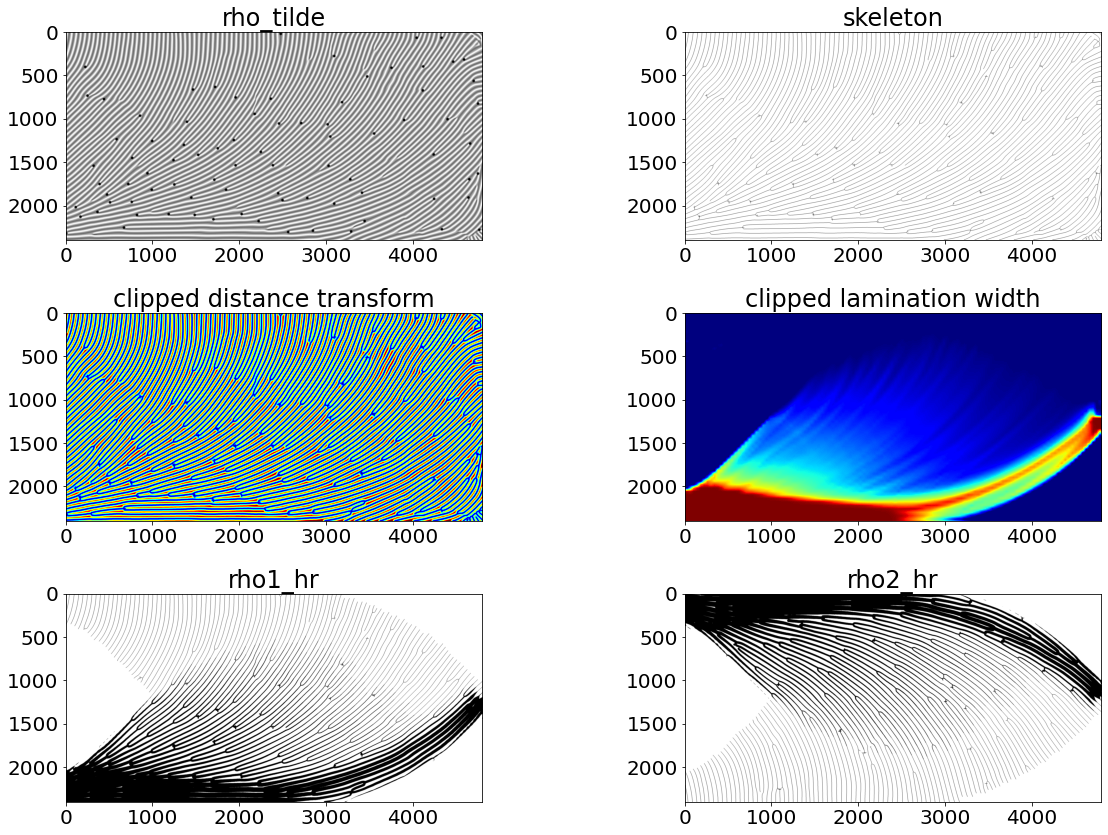

In [22]:
rho_tilde_period = get_hist_periodicity(rho1_tilde_np,rho2_tilde_np)
min_mu = float(mat_filename.split("_")[-4])
lam_proj = LaminationWidthProjection(rho_tilde_period,hmin=3,wmin=min_mu,nn_usr=8,field_usr=5,input_pad=npad)
RHOs = (rho1_tilde_np,rho2_tilde_np)
DOTs = (dot1_surf_np,dot2_surf_np)
MUs = (mu1,mu2)
rho_hr, rho1_hr, rho2_hr = lam_proj.forward(RHOs,DOTs,MUs,wmin_thres=True,refine_period=True,verbose=True,enable_plot=True)

# Final design

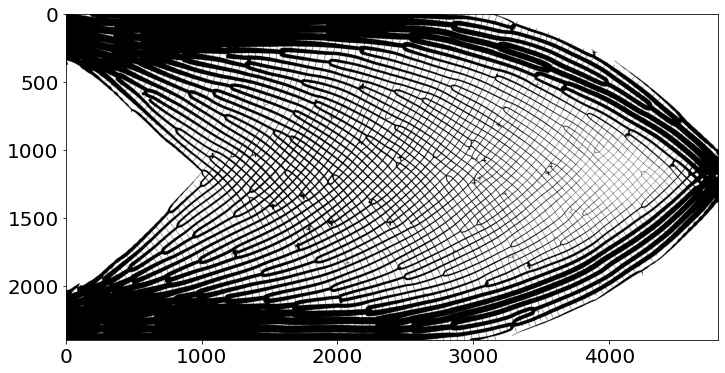

In [25]:
plt.figure(figsize=(12,6))
plt.imshow(-rho_hr,cmap='gray')
plt.show()